# Using fbprophet for forecasting of market data

In [13]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline
 
plt.rcParams['figure.figsize']=(20, 10)
plt.style.use('ggplot')

## Load data

Let's load our data to analyze.

In [14]:
market_df = pd.read_csv('SP500.csv', index_col='DATE', parse_dates=True)

In [15]:
market_df.tail()

,SP500
DATE,
2008-12-12,879.73
2008-12-11,873.59
2008-12-10,899.24
2008-12-09,888.67
2008-12-08,909.70


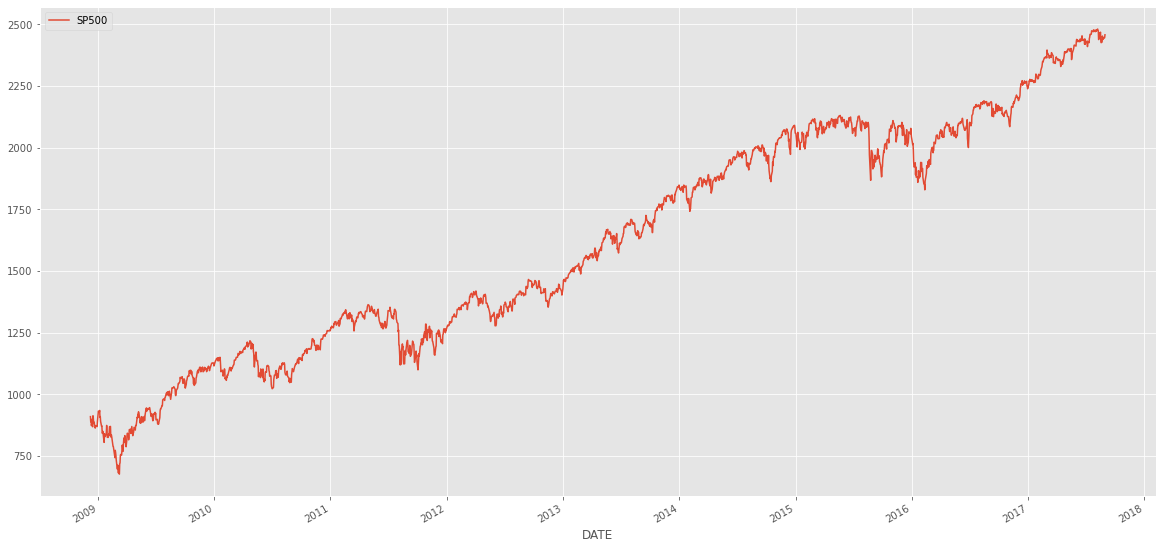

In [16]:
market_df.plot()

In [17]:
market_df.head()

,SP500
DATE,
2017-08-30,2457.59
2017-08-29,2446.30
2017-08-28,2444.24
2017-08-25,2443.05
2017-08-24,2438.97


## Prepare for fbprophet

In [18]:
df = market_df.reset_index().rename(columns={'DATE':'ds', 'SP500':'y'})
df['y'] = np.log(df['y'])

## Running fbprophet

instantiate prophet and fit our data (including our future dataframe).

In [19]:
model = Prophet()
model.fit(df);
future = model.make_future_dataframe(periods=365) #forecasting for 1 year from now.
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\opero\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


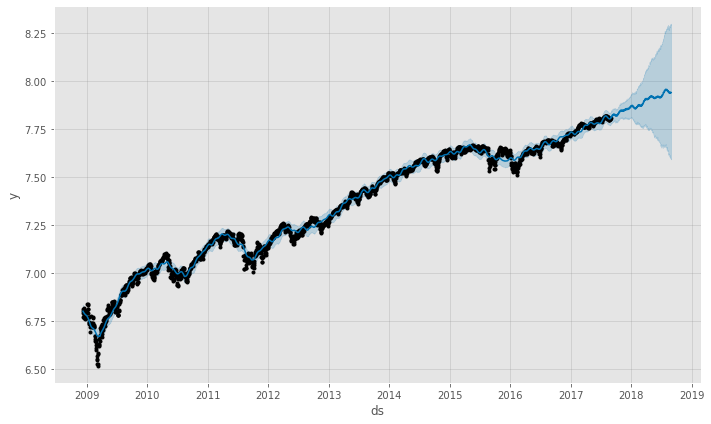

In [20]:
# Plotting the forecast

figure=model.plot(forecast)

With the data that we have, it is hard to see how good/bad the forecast (blue line) is compared to the actual data (black dots). Let's take a look at the last 800 data points (~2 years) of forecast vs actual without looking at the future forecast (because we are just interested in getting a visual of the error between actual vs forecast).

In [21]:
two_years = forecast.set_index('ds').join(market_df)
two_years = two_years[['SP500', 'yhat', 'yhat_upper', 'yhat_lower' ]].dropna().tail(800)
two_years['yhat']=np.exp(two_years.yhat) #for the use of np.exp() function, check link in Workflow.md
two_years['yhat_upper']=np.exp(two_years.yhat_upper)
two_years['yhat_lower']=np.exp(two_years.yhat_lower)

two_years.tail()

,SP500,yhat,yhat_upper,yhat_lower
ds,,,,
2017-08-24,2438.97,2445.526493,2522.331199,2367.987558
2017-08-25,2443.05,2445.086341,2523.610668,2362.837891
2017-08-28,2444.24,2447.216715,2530.133107,2370.351909
2017-08-29,2446.30,2450.020037,2535.523194,2371.810080
2017-08-30,2457.59,2452.662701,2532.726078,2372.651695


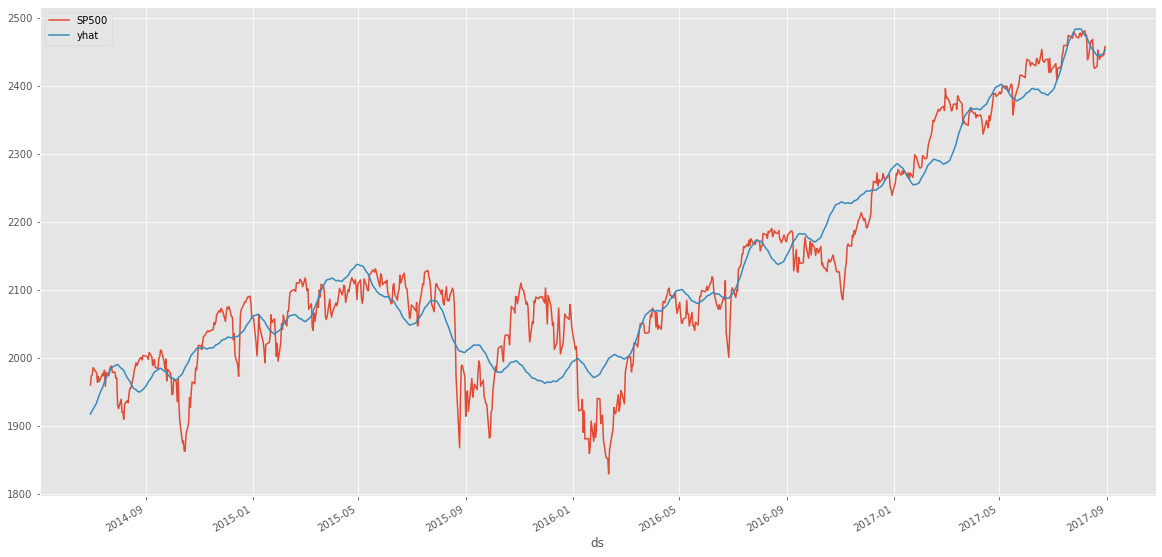

In [22]:
two_years[['SP500', 'yhat']].plot()

The forecast follows the trend quite well but doesn't seem to that great at catching the 'volatility' of the market. Don't fret though...this may be a very good thing though for us if we are interested in 'riding the trend' rather than trying to catch peaks and dips perfectly.

Let's take a look at a few measures of accuracy. First, 'average error'.

In [23]:
two_years_AE = (two_years.yhat - two_years.SP500)
print (two_years_AE.describe())

count    800.000000
mean      -0.681833
std       47.543293
min     -140.109738
25%      -29.831279
50%       -1.489072
75%       25.556344
max      169.851037
dtype: float64


First, let's look at R-squared.

R-squared looks good at 0.9

Now, let's look at mean squared error.

In [24]:
r2_score(two_years.SP500, two_years.yhat)

0.9057280107495564

In [25]:
mean_squared_error(two_years.SP500, two_years.yhat)

2258.004192139792

An MSE of 2250.79 for a model that is trying to predict the S&P500 with values between 1900 and 2500 isn't that good (remember...for MSE, closer to zero is better) if you are trying to predict exact changes and movements up/down.

Now, let's look at the mean absolute error (MAE). The MAE is the measurement of absolute error between two continuous variables and can give us a much better look at error rates than the standard mean.

In [26]:
mean_absolute_error(two_years.SP500, two_years.yhat)

36.13939029231278

Thus forecast by prophet isn't ideal to use this forecast in trading.

Another way to look at the usefulness of this forecast is to plot the upper and lower confidence bands of the forecast against the actuals - plotting yhat_upper and yhat_lower.

Text(0.5, 0, 'Date')

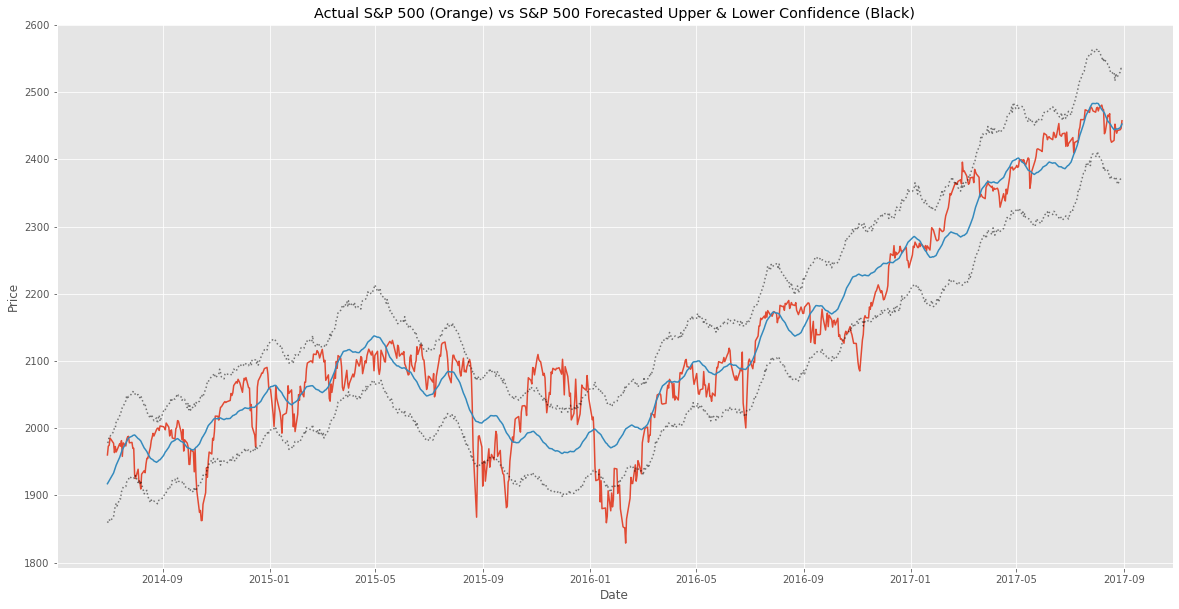

In [27]:
fig, ax1 = plt.subplots()
ax1.plot(two_years.SP500)
ax1.plot(two_years.yhat)
ax1.plot(two_years.yhat_upper, color='black',  linestyle=':', alpha=0.5)
ax1.plot(two_years.yhat_lower, color='black',  linestyle=':', alpha=0.5)

ax1.set_title('Actual S&P 500 (Orange) vs S&P 500 Forecasted Upper & Lower Confidence (Black)')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

In the above chart, we can see the forecast (in blue) vs the actuals (in orange) with the upper and lower confidence bands in gray.

You can't really tell anything quantifiable from this chart, but you can make a judgement on the value of the forecast. 

####  If you are trying to trade short-term (1 day to a few weeks) this forecast is almost useless 

#### but if you are investing with a timeframe of months to years, this forecast might provide some value to better understand the trend of the market and the forecasted trend.

Let's go back and look at the actual forecast to see if it might tell us anything different than the forecast vs the actual data.

In [28]:
full_df = forecast.set_index('ds').join(market_df)
full_df['yhat']=np.exp(full_df['yhat'])

IndexError: list index out of range

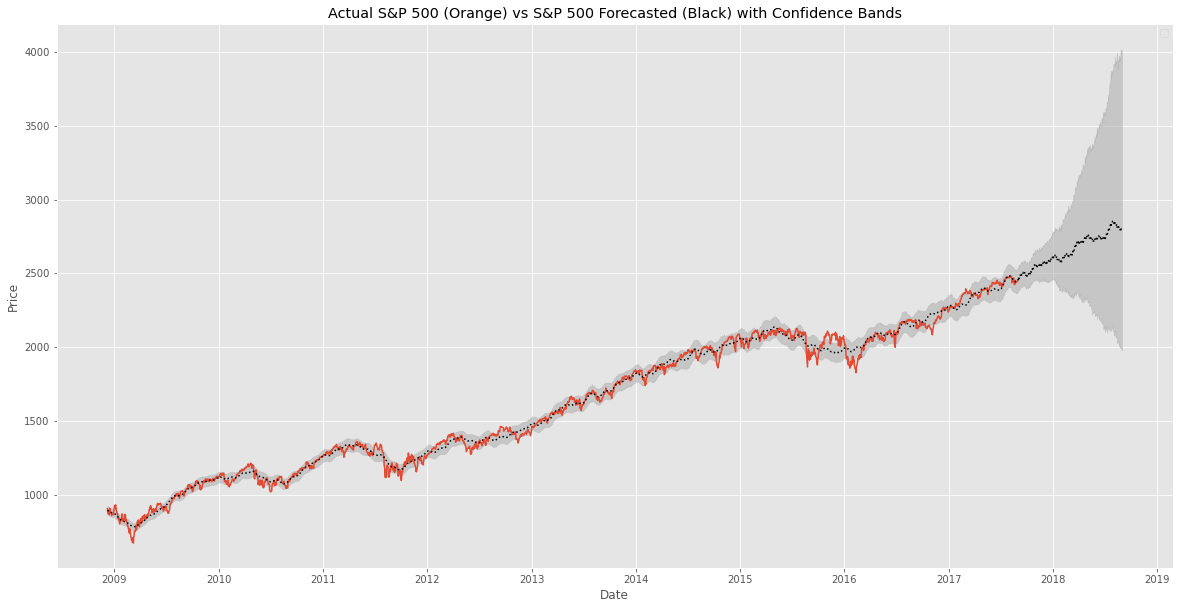

In [29]:
fig, ax1 = plt.subplots()
ax1.plot(full_df.SP500)
ax1.plot(full_df.yhat, color='black', linestyle=':')
ax1.fill_between(full_df.index, np.exp(full_df['yhat_upper']), np.exp(full_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('Actual S&P 500 (Orange) vs S&P 500 Forecasted (Black) with Confidence Bands')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('S&P 500 Actual') #change the legend text for 1st plot
L.get_texts()[1].set_text('S&P 5600 Forecasted') #change the legend text for 2nd plot

This chart is a bit easier to understand vs the default prophet chart (in my opinion at least). We can see throughout the history of the actuals vs forecast, that prophet does an OK job forecasting but has trouble with the areas when the market become very volatile.

Looking specifically at the future forecast, prophet is telling us that the market is going to continue rising and should be around 2750 at the end of the forecast period, with confidence bands stretching from 2000-ish to 4000-ish.

If you show this forecast to any serious trader / investor, they'd quickly shrug it off as a terrible forecast. Anything that has a 2000 point confidence interval is worthless in the short- and long-term investing world.

## Maybe we can use the forecast on weekly or monthly data with better accuracy. 

#### Or...maybe we can use the forecast combined with other forecasts to make a better forecast.